In [1]:
from Designer import makePart, DesignNotes, SST

# Example T15: Tension Member -  Angle Bolted Through One Leg

Calculate factored tension resistance, $T_r$, of a single angle bolted through one leg.
Assume 3/4" ASTM A325 bolts in 22mm punched holes, and CSA G40.21 350W steel.

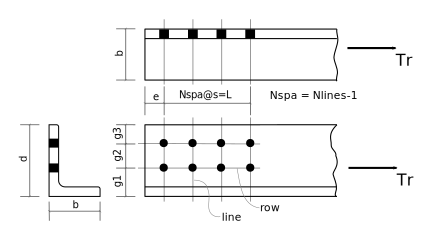

In [2]:
%figure bolted-single-angle.svg

_Note:_ The figure shows 2 rows of 4 bolts through one leg.  The logic below works for
1 or 2 rows and almost any number of bolts per row.  It also works for 1 or 2 angles, back-to-back.

### Import and Setup Library Modules

In [3]:
import pint                  # setup to use the module for computing with units
ureg = pint.UnitRegistry()
mm = ureg['mm']
inch = ureg['inch']
kN = ureg['kN']
MPa = ureg['MPa']
ureg.default_format = '~P'

In [4]:
notes = DesignNotes('Tr',units=kN,title='Angle bolted through single leg')

REQUIRE = notes.require   # useful abbreviations
CHECK = notes.check       
DATA = notes.DATA
GV = notes.GV

### Define the Design Parameters

In [5]:
@makePart
class Bolts:
    'Bolts'
    grade = 'ASTM A325'
    size = '3/4"'
    d = (3/4*inch).to(mm)
    Fu = 825*MPa
    Ab = 3.14159*d**2/4

In [6]:
Dsg = 'L178x102x13'
Ag,d,b,t = SST.section(Dsg,'A,D,B,T')
@makePart
class Angle:
    'Angle'
    grade = "CSA G40.21 350W",
    Fy = 350*MPa
    Fu = 450*MPa
    dsg = Dsg              # copy dimensions from SST
    Ag = Ag*mm*mm
    d = d*mm               # normally the long leg
    b = b*mm               # normally the short leg
    t = t*mm               # always the thickness :-)
    bolted_leg = 'long'    # 'long' (usually) or 'short'
    n = 1                  # number of angles (may be 1 or 2)
    threads_intercepted = True
    hole_type = 'punched'  # 'punched' or 'drilled'
    Nrows = 2              # a row is parallel to the load
    Nlines = 4             # a line is perpendicular to the load
    pitch = 75*mm          # spacing measured parallel to load (along length of angle)
    end_distance = 35*mm   # from end of angle to center of closest hole
    # for one row of bolts:
    g = 100*mm
    # for two rows of bolts:
    g1 = 65*mm             # gauge to first row of bolts, CISC HB-11 p. 6-173
    g2 = 80*mm             # gauge to second row of bolts, or 0 if only 1 row

    # ha = hole allowance by CSA S16-14 12.3.2:
    ha = 22*mm + (0*mm if hole_type == 'drilled' else 2*mm)

    if bolted_leg == 'short':
        d,b = b,d           # d will always be dimension of bolted leg

    if Nrows == 1:                   # below we will use only g1, g2, g3
        g1 = g
        g2 = 0*mm
    elif Nrows == 2:
        g = 0*mm

### Sanity check of input data:

If any of these requirements are not met, execution will stop with an error message.

In [7]:
REQUIRE(Angle.hole_type in ['punched','drilled'], 
    "Value of 'Angle.hole_type' must be punched or drilled")
REQUIRE(Angle.threads_intercepted in [False,True],
    "Value of 'Angle.threads_intercepted' must be True or False")
REQUIRE(Angle.n in [1,2], 
    'Number of angles, Angle.n, must be 1 or 2')
REQUIRE(Angle.bolted_leg in ['short','long'],
    "Value of 'Angle.bolted_leg' must be short or long")
REQUIRE(Angle.Nrows in [1,2],
    "Angle.Nrows must be 1 or 2")
REQUIRE(Angle.Nlines >= 2 and Angle.Nlines <= 10,
    "Angle.Nlines must be in range of 2 to 10")

### Check Bolting Details
Failure to meet criteria is not a fatal error. Results are reported in the work record.

In [8]:
# data derived from input data:  pitch, end_distance, gauges, etc.
with DATA('','',
          GV('Ag,d,b,t,pitch,g1,g2,end_distance,Nrows,Nlines',Angle),
          GV('bolt_diameter=d',Bolts),
          GV('g3')):
    minimum_pitch = 2.7*bolt_diameter         # CSA S16-14 22.3.1
    min_edge_distance = 25*mm                 # CSA S16-14 22.3.2, Table 6, 3/4", rolled edge
    min_end_distance = min_edge_distance      # CSA S16-14 22.3.3                    
    if Nlines <= 2:
        min_end_distance = 1.5*bolt_diameter  # CSA S16-01 22.3.4
    max_edge_distance = min(150*mm,12*t)

    g3 = edge_distance = d-(g1+g2)
    Angle.g3 = g3
    Angle.edge_distance = g3
    
    REQUIRE(edge_distance > bolt_diameter/2.,
        'Angle leg of {0} does not allow {1} lines of bolts.'.format(d,Nrows))
    CHECK(pitch >= minimum_pitch,
        'Pitch greater than minimum','pitch,minimum_pitch')
    if Nrows > 1:
        CHECK(g2 >= minimum_pitch,
            'Gauge g2 greater than minimum pitch','g2,minimum_pitch')
    CHECK(edge_distance >= min_edge_distance,
        'Edge distance greater than minimum','edge_distance,min_edge_distance')
    CHECK(edge_distance <= max_edge_distance,
        'Edge distance less than maximum','edge_distance,max_edge_distance')
    CHECK(end_distance >= min_end_distance,
        'End distance greater than minimum','end_distance,min_end_distance')

    Pitch greater than minimum?  OK 
      (pitch=75mm, minimum_pitch=51.43mm)
    Gauge g2 greater than minimum pitch?  OK 
      (g2=80mm, minimum_pitch=51.43mm)
    Edge distance greater than minimum?  OK 
      (edge_distance=33.0mm, min_edge_distance=25mm)
    Edge distance less than maximum?  OK 
      (edge_distance=33.0mm, max_edge_distance=150mm)
    End distance greater than minimum?  OK 
      (end_distance=35mm, min_end_distance=25mm)
Ag            = 3390  mm²
d             = 178   mm
b             = 102   mm
t             = 12.7  mm
pitch         = 75    mm
g1            = 65    mm
g2            = 80    mm
end_distance  = 35    mm
Nrows         = 2     
Nlines        = 4     
bolt_diameter = 19.05 mm
g3            = 33    mm


## Strength Calculations

In [9]:
# CSA S16-14  13.1
phi = 0.90
phiu = 0.75
phib = 0.80 
phibr = 0.80

### Gross section yield:

In [10]:
# CSA S16-14   13.2 (a) (i):
with DATA('Tr', 'Gross area yield',
          GV('Ag,Fy,n',Angle)):
    Tr = phi*Ag*Fy*n

Ag    = 3390      mm²
Fy    = 350       MPa
n     = 1         
Tr    = 1.068e+06 MPa·mm²



    Gross area yield: Tr = 1068 kN

### Net section fracture:
There is only one possible failure path - through the rightmost bolt hole(s).

In [11]:
# CSA S16-14   13.2 (a) (iii):
with DATA('Tr', 'Net area fracture',
          GV('Nrows,Nlines,ha,Ag,t,Fu,n',Angle),GV('An,Ane')):

    An = Ag - Nrows*ha*t                # CSA S16-14 12.3.1 a)
    if Nlines >= 4:                     # CSA S16-14 12.3.3.2 (b)
        Ane = 0.80*An
    else:
        Ane = 0.60*An
    Tr = phiu*Ane*Fu*n

Nrows  = 2      
Nlines = 4      
ha     = 24     mm
Ag     = 3390   mm²
t      = 12.7   mm
Fu     = 450    MPa
n      = 1      
An     = 2780   mm²
Ane    = 2224   mm²
Tr     = 750700 MPa·mm²



    Net area fracture: Tr = 750.7 kN

### Block shear failure:

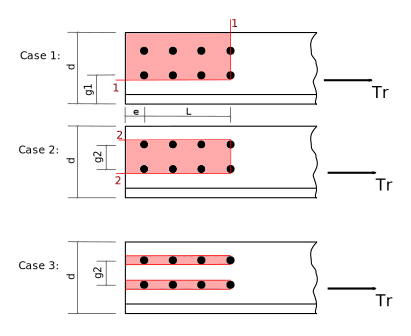

In [12]:
%figure "bolted-single-angle-shear-blocks.svg"

In [13]:
#  CSA S16-14    13.11
with DATA('Tr', 'Block shear (case 1)',
          GV('Nrows,Nlines,ha,e=end_distance,s=pitch,g1,d,t,Fy,Fu,n',Angle),
          GV('An,Agv,Ut')): # global phiu, Fv, L
    L = (Nlines-1.)*s

    # Case 1 - one shear area, tension failure from furthest bolt to edge
    An = (d - g1 - (Nrows-0.5)*ha)*t
    Agv = (e+L)*t
    Ut = 0.6
    Fv = (Fy+Fu)/2.
    if Fy > 460*MPa:     # CSA S16-14 13.11  (foot note)
        Fv = Fy
    Tr = n*phiu*(Ut*An*Fu + 0.6*Agv*Fv)

Nrows  = 2      
Nlines = 4      
ha     = 24     mm
e      = 35     mm
s      = 75     mm
g1     = 65     mm
d      = 178    mm
t      = 12.7   mm
Fy     = 350    MPa
Fu     = 450    MPa
n      = 1      
An     = 977.9  mm²
Agv    = 3302   mm²
Ut     = 0.6    
Tr     = 792400 MPa·mm²



    Block shear (case 1): Tr = 792.4 kN

In [14]:
# Case 2 - for 2 or more rows of bolts    CSA S16-14 13.11
with DATA('','',GV('Nrows',Angle),showdata=False):
    if Nrows > 1:
        with DATA('Tr', 'Block shear (case 2)',
                  GV('n,g2,ha,t,e=end_distance,Fu',Angle),GV('An,Agv,Ut')):  # globals='L,phiu'
            An = (g2 - ha)*t
            Agv = 2.*(e+L)*t
            Ut = 0.6
            Tr = n*phiu*(Ut*An*Fu + 0.6*Agv*Fv)

n     = 1         
g2    = 80        mm
ha    = 24        mm
t     = 12.7      mm
e     = 35        mm
Fu    = 450       MPa
An    = 711.2     mm²
Agv   = 6604      mm²
Ut    = 0.6       
Tr    = 1.333e+06 MPa·mm²



    Block shear (case 2): Tr = 1333 kN

In [15]:
# Case 3 - tearout     CSA S16-14 13.11 
with DATA('Tr', 'Block shear (tearout)',
          GV('n,Nrows,t,e=end_distance,Fu',Angle),GV('An,Agv,Ut')):  # globals='L,phiu'
    An = 0.*mm*mm
    Agv = 2.*(e+L)*t*Nrows
    Ut = 0.
    Tr = n*phiu*(Ut*An*Fu + 0.6*Agv*Fv)

n     = 1         
Nrows = 2         
t     = 12.7      mm
e     = 35        mm
Fu    = 450       MPa
An    = 0         mm²
Agv   = 13210     mm²
Ut    = 0         
Tr    = 2.377e+06 MPa·mm²



    Block shear (tearout): Tr = 2377 kN

### Fastener strength, bearing-type connection: bolts in shear

In [16]:
with DATA('Vr', 'Bolt Shear',
          GV('m=n,threads_intercepted,s=pitch,Nrows,Nlines,n',Angle),
          GV('Ab,Fu,bd=d',Bolts),
          GV('L,multiplier')):  # globals='nbolts,phib'

    nbolts = Nrows*Nlines
    L = (Nlines-1.)*s   # length of connection

    # CSA S16-14   13.12.1.2 (c)
    multiplier = 1.0
    if L >= 760.*mm:
        multiplier *= 0.5/0.6
    if threads_intercepted:
        multiplier *= 0.70
    Vr = multiplier*0.6*phib*nbolts*m*Ab*Fu

m                   = 1      
threads_intercepted = True   
s                   = 75     mm
Nrows               = 2      
Nlines              = 4      
n                   = 1      
Ab                  = 285    mm²
Fu                  = 825    MPa
bd                  = 19.05  mm
L                   = 225    mm
multiplier          = 0.7    
Vr                  = 632100 MPa·mm²



    Bolt Shear: Tr = 632.1 kN    <<<--- GOVERNS

### Bolts in bearing:

In [17]:
# CSA S16-14    13.12.1.2 a):
with DATA('Br', 'Bolt Bearing',
          GV('Fu,t,n,nbolts=Nrows*Nlines',Angle),
          GV('d',Bolts)): # globals='phibr,nbolts'
    Br = 3.*phibr*nbolts*t*d*Fu * n

Fu     = 450      MPa
t      = 12.7     mm
n      = 1        
nbolts = 8        
d      = 19.05    mm
Br     = 2.09e+06 MPa·mm²



    Bolt Bearing: Tr = 2090 kN

#### Combined tearout and bearing:

In [18]:
# combine tearout of bolts closest to end with bearing of remainder
with DATA('Tr', 'Bolt bearing + end tearout',
          GV('t,e=end_distance,Nlines,Nrows,nangles=n,Fu',Angle),
          GV('db=d',Bolts),
          GV('Agv,nbolts,Tr2,Br')): # globals='phiu,phibr,Fv'
    Agv = 2.*e*t*Nrows
    nbolts = Nrows*(Nlines-1)
    Tr2 = nangles*(phiu*(0.6*Agv*Fv)).to(kN)    # S16-14 13.11
    Br = nangles*(3.*phibr*nbolts*t*db*Fu).to(kN)     # S16-14 13.12.1.2 b)
    Tr = Tr2+Br

t       = 12.7  mm
e       = 35    mm
Nlines  = 4     
Nrows   = 2     
nangles = 1     
Fu      = 450   MPa
db      = 19.05 mm
Agv     = 1778  mm²
nbolts  = 6     
Tr2     = 320   kN
Br      = 1568  kN
Tr      = 1888  kN



    Bolt bearing + end tearout: Tr = 1888 kN

In [19]:
# combine block shear of bolts closes to end with bearing of remainder (CSA S16-14: 13.12.1.2 b))
with DATA('','',GV('Nrows',Angle),showdata=False):
    if Nrows > 1:
        with DATA('Tr', 'Bolt bearing + end block shear (case 2)',
                  GV('e=end_distance,t,g2,ha,Fu,nangles=n,Nlines',Angle),
                  GV('db=d',Bolts),
                  GV('Agv,Tr2,Br,Ut,n')): #  globals='phiu,phibr,Fv'
            An = (g2 - ha)*t
            Agv = 2.*e*t
            Ut = 0.6
            Tr2 = nangles*(phiu*(Ut*An*Fu + 0.6*Agv*Fv)).to(kN)      # S16-14 13.11
            n = Nrows*(Nlines-1)
            Br = nangles*(3.*phibr*n*t*db*Fu).to(kN)    # S16-14 13.12.1.2 b)
            Tr = Tr2+Br    

e       = 35    mm
t       = 12.7  mm
g2      = 80    mm
ha      = 24    mm
Fu      = 450   MPa
nangles = 1     
Nlines  = 4     
db      = 19.05 mm
Agv     = 889   mm²
Tr2     = 304   kN
Br      = 1568  kN
Ut      = 0.6   
n       = 6     
Tr      = 1872  kN



    Bolt bearing + end block shear (case 2): Tr = 1872 kN

## Summary:

In [20]:
notes.summary()          


Summary of DesignNotes for Tr: Angle bolted through single leg

Checks:
-------
    Pitch greater than minimum?            OK 
      (pitch=75mm, minimum_pitch=51.43mm)
    Gauge g2 greater than minimum pitch?   OK 
      (g2=80mm, minimum_pitch=51.43mm)
    Edge distance greater than minimum?    OK 
      (edge_distance=33.0mm, min_edge_distance=25mm)
    Edge distance less than maximum?       OK 
      (edge_distance=33.0mm, max_edge_distance=150mm)
    End distance greater than minimum?     OK 
      (end_distance=35mm, min_end_distance=25mm)

Values of Tr:
-------------
    Gross area yield:                        Tr = 1070 kN
    Net area fracture:                       Tr = 751 kN
    Block shear (case 1):                    Tr = 792 kN
    Block shear (case 2):                    Tr = 1330 kN
    Block shear (tearout):                   Tr = 2380 kN
    Bolt Shear:                              Tr = 632 kN    <<<--- GOVERNS
    Bolt Bearing:                            Tr = 2090 